In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy 
import math
import scipy.stats as scs
from scipy import special,sparse
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs:100

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))   #50,50
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))
#Returns the argument x for which the area under the Gaussian 
#probability density function (integrated from minus infinity to x) is equal to y

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [3]:
# -------- Insert your code here -------- #
Ndrivers = len(rho)

# Generating Scenarios
# -------- Insert your code here -------- #

y = np.zeros((Nout,Ndrivers))

Losses_out = np.zeros((Nout,K))

for s in range(1,Nout+1):
    # -------- Insert your code here -------- #
    
    normal_random_vector = np.random.randn(Ndrivers,1)
    y[s-1,:] = np.dot(sqrt_rho,normal_random_vector).T
    z = np.random.randn(K,1)
    
    for k in range(1,K+1):

        cd = int(driver[k-1])

        w = beta[k-1] * y[s-1,cd] + np.sqrt(1 - beta[k-1]**2) * z[k-1]
        
        temp = np.append(w,CS_Bdry[k-1,:])
        
        temp = sorted(temp)
        
        cs_index = np.argwhere(temp == w)
        
        Losses_out[s-1,k-1] = exposure[k-1,cs_index]

In [4]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2) equally weighted
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)   1,1,1,1....
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)   not integers?????

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
        
        Losses = sorted(np.dot(Losses_out,x0[portN]))
        VaRout[portN, q] = Losses[int(math.ceil(Nout * alf)) -1]
        VaRinN[portN, q] = np.mean(Losses) + scs.norm.ppf(alf) * np.std(Losses)
        CVaRout[portN, q] = (1 / (Nout*(1-alf))) * ((math.ceil(Nout*alf)-Nout*alf) * VaRout[portN,q] + sum(Losses[int(math.ceil(Nout*alf)):]))
        CVaRinN[portN, q] = np.mean(Losses) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * np.std(Losses)

In [6]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}


for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    
    y_inMC1 = np.zeros((np.int(np.ceil(Nin/Ns)),Ndrivers))
    Losses_inMC1 = np.zeros((Nin,K))

    for s in range(1, np.int(np.ceil(Nin / Ns) + 1)): # systemic scenarios   1000
        # -------- Insert your code here -------- #
       
        normal_random_vector = np.random.randn(Ndrivers,1)
        y_inMC1[s-1,:] = np.dot(sqrt_rho,normal_random_vector).T
        
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic 5
            # -------- Insert your code here -------- #
            z_inMC1 = np.random.randn(K,1)
            
            # Calculate losses for MC1 approximation (5000 x 100)
            # Losses_inMC1
    
            for k in range(1,K+1): #100
            
                cd = int(driver[k-1])

                w_inMC1 = beta[k-1] * y_inMC1[s-1,cd] + np.sqrt(1 - beta[k-1]**2) * z_inMC1[k-1]

                temp_inMC1 = np.append(w_inMC1,CS_Bdry[k-1,:])

                temp_inMC1 = sorted(temp_inMC1)

                cs_index = np.argwhere(temp_inMC1==w_inMC1)

                Losses_inMC1[5*(s-1)+si-1,k-1] = exposure[k-1,cs_index]
            
            
    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #
    
    y_inMC2 = np.zeros((Nin,Ndrivers))
    
    Losses_inMC2 = np.zeros((Nin,K))

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        
        normal_random_vector = np.random.randn(Ndrivers,1)
        y_inMC2[s-1,:] = np.dot(sqrt_rho,normal_random_vector).T
        z_inMC2 = np.random.randn(K,1)
    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2
    
        for k in range(1,K+1):
            
                cd = int(driver[k-1])

                w_inMC2 = beta[k-1] * y_inMC2[s-1,cd] + np.sqrt(1 - beta[k-1]**2) * z_inMC2[k-1]

                temp_inMC2 = np.append(w_inMC2,CS_Bdry[k-1,:])

                temp_inMC2 = sorted(temp_inMC2)

                cs_index = np.argwhere(temp_inMC2==w_inMC2)

                Losses_inMC2[s-1,k-1] = exposure[k-1,cs_index]

                
    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #

    
            # Compute portfolio loss
            portf_loss_inMC1 = sorted(np.dot(Losses_inMC1,x0[portN]))
            portf_loss_inMC2 = sorted(np.dot(Losses_inMC2,x0[portN]))
            
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            mu_p_MC1 = np.dot(mu_MC1,x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            mu_p_MC2 = np.dot(mu_MC2,x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            
            # Compute VaR and CVaR for the current trial
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) -1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) -1]
            
            VaRinN1[portN, q][tr - 1] = mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] = mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC1[portN,q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC2[portN,q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))
            
            CVaRinN1[portN, q][tr - 1] = mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] = mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC2


In [7]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $38795248.04, CVaR 99.0% = $46677193.65
In-sample MC1: VaR 99.0% = $38697117.21, CVaR 99.0% = $46484356.35
In-sample MC2: VaR 99.0% = $38500874.79, CVaR 99.0% = $46407903.71
In-sample No: VaR 99.0% = $27063904.37, CVaR 99.0% = $30071198.64
In-sample N1: VaR 99.0% = $26830604.01, CVaR 99.0% = $29813683.92
In-sample N2: VaR 99.0% = $26890550.43, CVaR 99.0% = $29878298.10

Out-of-sample: VaR 99.9% = $56908684.40, CVaR 99.9% = $65071657.25
In-sample MC1: VaR 99.9% = $55797812.47, CVaR 99.9% = $63543284.95
In-sample MC2: VaR 99.9% = $56149801.90, CVaR 99.9% = $63806744.51
In-sample No: VaR 99.9% = $33843052.84, CVaR 99.9% = $36300047.45
In-sample N1: VaR 99.9% = $33555167.63, CVaR 99.9% = $35992378.84
In-sample N2: VaR 99.9% = $33625636.27, CVaR 99.9% = $36066661.08


Portfolio 2:

Out-of-sample: VaR 99.0% = $28114381.82, CVaR 99.0% = $34243327.37
In-sample MC1: VaR 99.0% = $27797626.13, CVaR 99.0% = $33875835.39
In-sample MC2: VaR 99.0% = $27803693

## Portfolio 1

#### out-of-sample vs. Normal model at 99% level

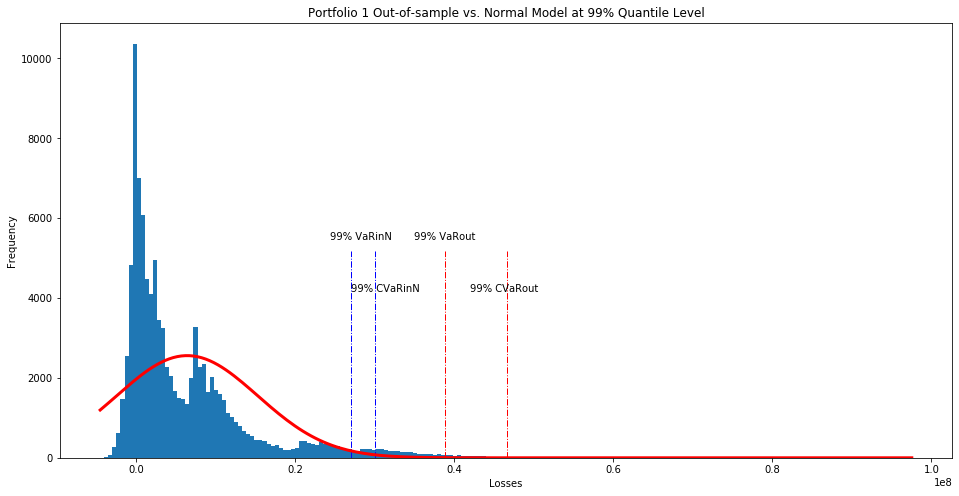

In [17]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[0]), 200)
normf= (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * VaRout[0,0], max(frequencyCounts) / 1.9, '99% VaRout')
plt.text(0.9 * VaRinN[0,0], max(frequencyCounts) / 1.9, '99% VaRinN')
plt.text(0.9 * CVaRout[0,0], max(frequencyCounts) / 2.5, '99% CVaRout')
plt.text(0.9 * CVaRinN[0,0], max(frequencyCounts) / 2.5, '99% CVaRinN')
plt.title('Portfolio 1 Out-of-sample vs. Normal Model at 99% Quantile Level')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

#### out-of-sample vs. Normal model at 99.9% level

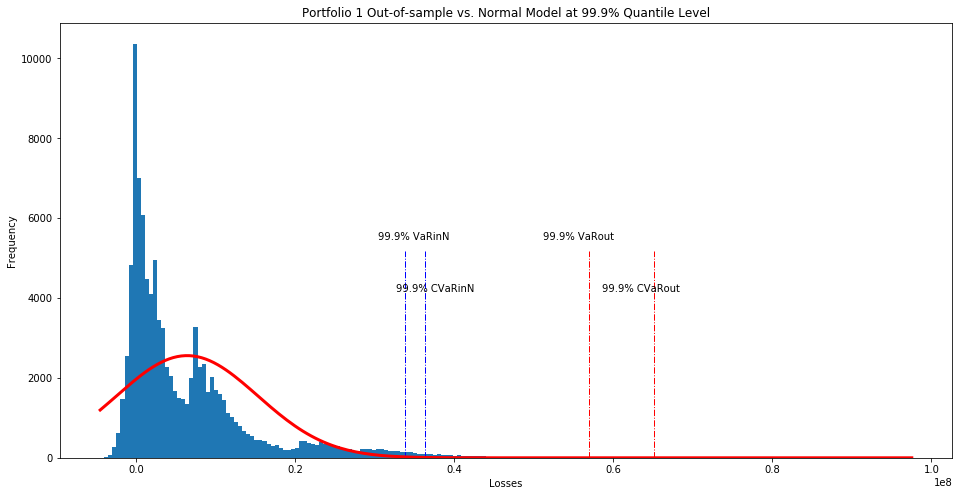

In [18]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[0]), 200)
normf= (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * VaRout[0,1], max(frequencyCounts) / 1.9, '99.9% VaRout')
plt.text(0.9 * VaRinN[0,1], max(frequencyCounts) / 1.9, '99.9% VaRinN')
plt.text(0.9 * CVaRout[0,1], max(frequencyCounts) / 2.5, '99.9% CVaRout')
plt.text(0.9 * CVaRinN[0,1], max(frequencyCounts) / 2.5, '99.9% CVaRinN')
plt.title('Portfolio 1 Out-of-sample vs. Normal Model at 99.9% Quantile Level')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

#### Out-of-sample

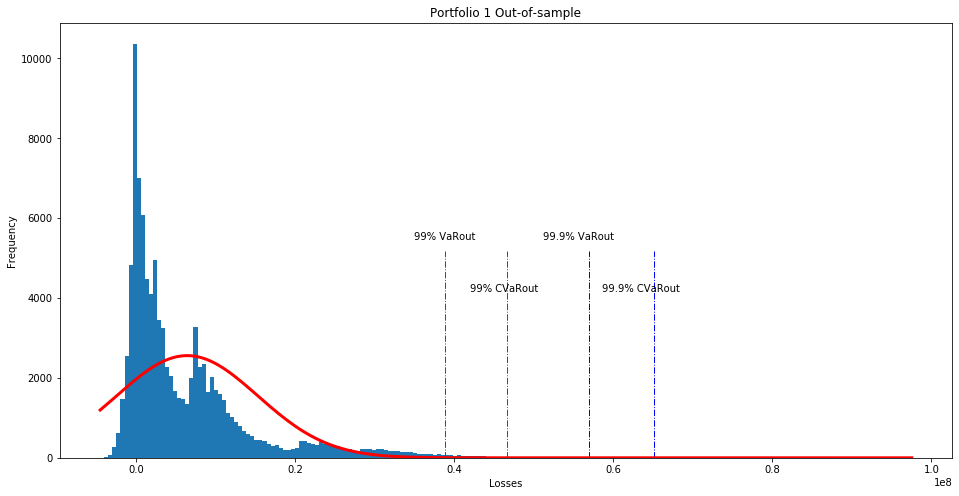

In [8]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[0]), 200)
normf= (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * VaRout[0,0], max(frequencyCounts) / 1.9, '99% VaRout')
plt.text(0.9 * VaRout[0,1], max(frequencyCounts) / 1.9, '99.9% VaRout')
plt.text(0.9 * CVaRout[0,0], max(frequencyCounts) / 2.5, '99% CVaRout')
plt.text(0.9 * CVaRout[0,1], max(frequencyCounts) / 2.5, '99.9% CVaRout')
plt.title('Portfolio 1 Out-of-sample')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

#### Monte-Carlo 1

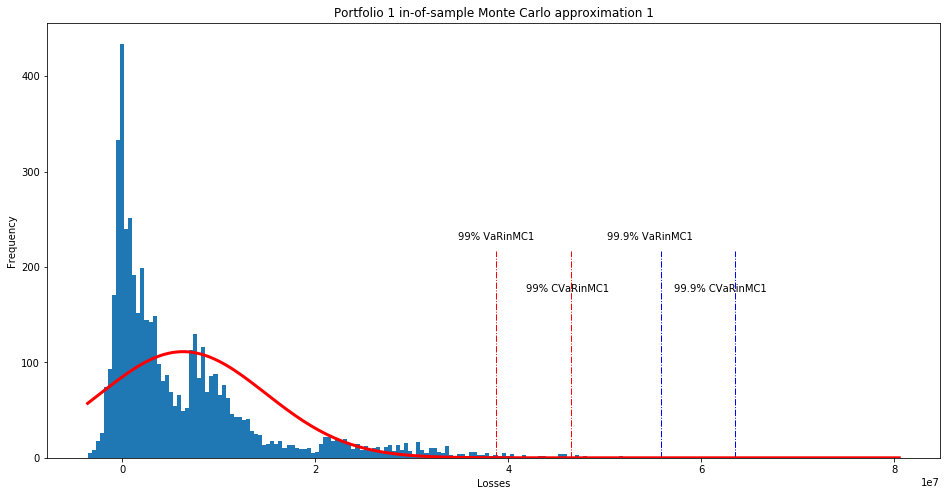

In [14]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[0]), 200)
normf= (1 / (np.std(np.dot(Losses_inMC1,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC1,x0[0]))) / np.std(np.dot(Losses_inMC1,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC1[0,0]), np.mean(VaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC1[0,1]), np.mean(VaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,0]), np.mean(CVaRinMC1[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[0,1]), np.mean(CVaRinMC1[0,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * np.mean(VaRinMC1[0,0]), max(frequencyCounts) / 1.9, '99% VaRinMC1')
plt.text(0.9 * np.mean(VaRinMC1[0,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC1')
plt.text(0.9 * np.mean(CVaRinMC1[0,0]), max(frequencyCounts) / 2.5, '99% CVaRinMC1')
plt.text(0.9 * np.mean(CVaRinMC1[0,1]), max(frequencyCounts) / 2.5, '99.9% CVaRinMC1')
plt.title('Portfolio 1 in-of-sample Monte Carlo approximation 1')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

#### Monte-Carlo 2

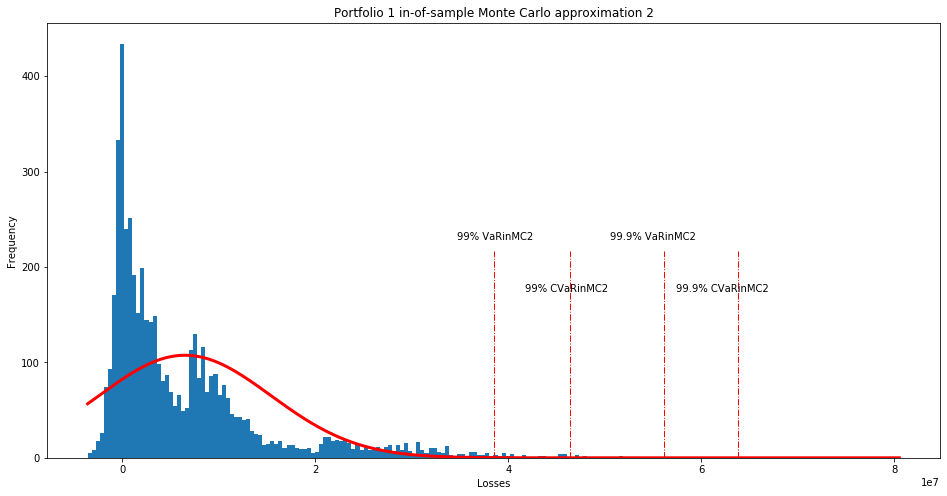

In [15]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[0]), 200)
normf= (1 / (np.std(np.dot(Losses_inMC2,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC2,x0[0]))) / np.std(np.dot(Losses_inMC2,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC2[0,0]), np.mean(VaRinMC2[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC2[0,1]), np.mean(VaRinMC2[0,1])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,0]), np.mean(CVaRinMC2[0,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[0,1]), np.mean(CVaRinMC2[0,1])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * np.mean(VaRinMC2[0,0]), max(frequencyCounts) / 1.9, '99% VaRinMC2')
plt.text(0.9 * np.mean(VaRinMC2[0,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC2')
plt.text(0.9 * np.mean(CVaRinMC2[0,0]), max(frequencyCounts) / 2.5, '99% CVaRinMC2')
plt.text(0.9 * np.mean(CVaRinMC2[0,1]), max(frequencyCounts) / 2.5, '99.9% CVaRinMC2')
plt.title('Portfolio 1 in-of-sample Monte Carlo approximation 2')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

## Portfolio 2

#### Out-of-Sample

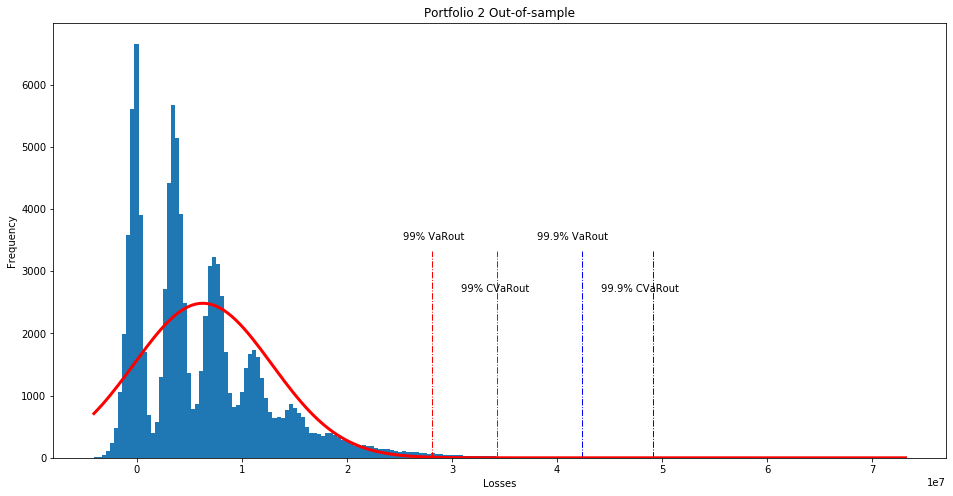

In [11]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[1]), 200)
normf= (1 / (np.std(np.dot(Losses_out,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_out,x0[1]))) / np.std(np.dot(Losses_out,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * VaRout[1,0], max(frequencyCounts) / 1.9, '99% VaRout')
plt.text(0.9 * VaRout[1,1], max(frequencyCounts) / 1.9, '99.9% VaRout')
plt.text(0.9 * CVaRout[1,0], max(frequencyCounts) / 2.5, '99% CVaRout')
plt.text(0.9 * CVaRout[1,1], max(frequencyCounts) / 2.5, '99.9% CVaRout')
plt.title('Portfolio 2 Out-of-sample')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

#### Monte-Carlo 1

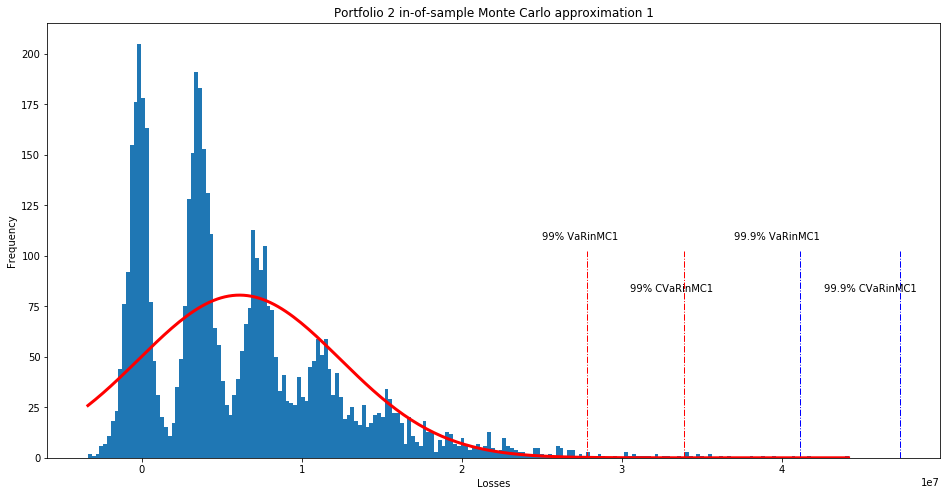

In [12]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC1,x0[1]), 200)

normf= (1 / (np.std(np.dot(Losses_inMC1,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC1,x0[1]))) / np.std(np.dot(Losses_inMC1,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC1[1,0]), np.mean(VaRinMC1[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC1[1,1]), np.mean(VaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,0]), np.mean(CVaRinMC1[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC1[1,1]), np.mean(CVaRinMC1[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * np.mean(VaRinMC1[1,0]), max(frequencyCounts) / 1.9, '99% VaRinMC1')
plt.text(0.9 * np.mean(VaRinMC1[1,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC1')
plt.text(0.9 * np.mean(CVaRinMC1[1,0]), max(frequencyCounts) / 2.5, '99% CVaRinMC1')
plt.text(0.9 * np.mean(CVaRinMC1[1,1]), max(frequencyCounts) / 2.5, '99.9% CVaRinMC1')
plt.title('Portfolio 2 in-of-sample Monte Carlo approximation 1')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

#### Monte-Carlo 2

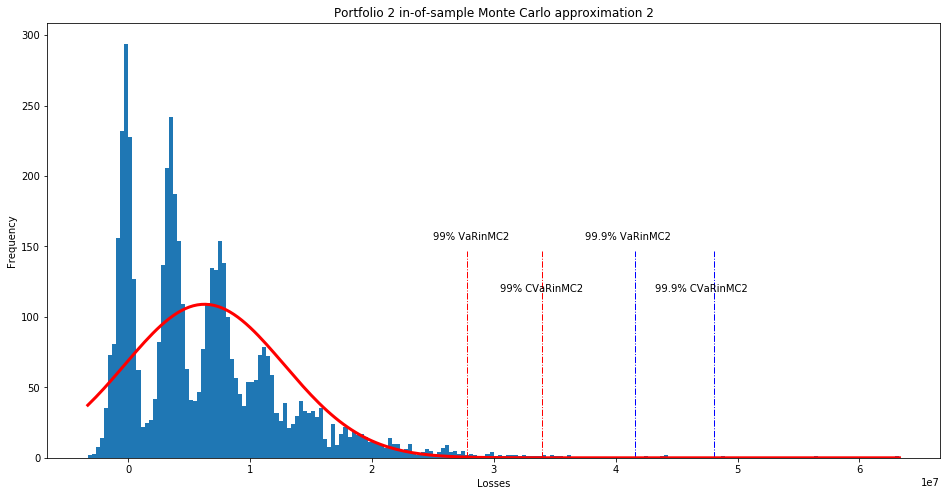

In [13]:
plt.figure(figsize=(16,8))

frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[1]), 200)
normf= (1 / (np.std(np.dot(Losses_inMC2,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(np.dot(Losses_inMC2,x0[1]))) / np.std(np.dot(Losses_inMC2,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

plt.plot([np.mean(VaRinMC2[1,0]), np.mean(VaRinMC2[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(VaRinMC2[1,1]), np.mean(VaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,0]), np.mean(CVaRinMC2[1,0])], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([np.mean(CVaRinMC2[1,1]), np.mean(CVaRinMC2[1,1])], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.plot(binLocations, normf, color='r', linewidth=3.0)

plt.text(0.9 * np.mean(VaRinMC2[1,0]), max(frequencyCounts) / 1.9, '99% VaRinMC2')
plt.text(0.9 * np.mean(VaRinMC2[1,1]), max(frequencyCounts) / 1.9, '99.9% VaRinMC2')
plt.text(0.9 * np.mean(CVaRinMC2[1,0]), max(frequencyCounts) / 2.5, '99% CVaRinMC2')
plt.text(0.9 * np.mean(CVaRinMC2[1,1]), max(frequencyCounts) / 2.5, '99.9% CVaRinMC2')
plt.title('Portfolio 2 in-of-sample Monte Carlo approximation 2')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.show()

# Mean and Stds

#### out-pf-sample

In [24]:
# portfolio 1
out_loss_1 = sorted(np.dot(Losses_out,x0[0]))
mean_loss_1 = np.mean(out_loss_1)
std_loss_1 = np.std(out_loss_1)

# portfolio 2
out_loss_2 = sorted(np.dot(Losses_out,x0[1]))
mean_loss_2 = np.mean(out_loss_2)
std_loss_2 = np.std(out_loss_2)

#### in-sample MC1

In [31]:
# portfolio 1
mc1_loss_1 = sorted(np.dot(Losses_inMC1,x0[0]))
mc1_mean_1 = np.dot(mu_MC1,x0[0])
mc1_std_1 = np.std(mc1_loss_1)

# portfolio 2
mc1_loss_2 = sorted(np.dot(Losses_inMC2,x0[1]))
mc1_mean_2 = np.dot(mu_MC1,x0[1])
mc1_std_2 = np.std(mc1_loss_2)

#### in-sample MC2

In [26]:
# portfolio 1
mc2_loss_1 = sorted(np.dot(Losses_inMC2,x0[0]))
mc2_mean_1 = np.dot(mu_MC2,x0[0])
mc2_std_1 = np.std(mc2_loss_1)

# portfolio 2
mc2_loss_2 = sorted(np.dot(Losses_inMC2,x0[1]))
mc2_mean_2 = np.dot(mu_MC2,x0[1])
mc2_std_2 = np.std(mc2_loss_2)

In [34]:
pd.options.display.float_format = '${:,.2f}'.format

In [42]:
#portfolio 1
print('Portfolio 1')
display(pd.DataFrame([[mean_loss_1,mc1_mean_1,mc2_mean_1],[std_loss_1,mc1_std_1,mc2_std_1]],index=['Means','Standard Deviations'],
            columns=['out-sample','MC1','MC2']))

print('Portfolio 2')
#portfolio 2
display(pd.DataFrame([[mean_loss_2,mc1_mean_2,mc2_mean_2],[std_loss_2,mc1_std_2,mc2_std_2]],index=['Means','Standard Deviations'],
            columns=['out-sample','MC1','MC2']))

Portfolio 1


,out-sample,MC1,MC2
Means,"$6,418,559.40","$6,305,178.11","$6,500,125.14"
Standard Deviations,"$8,874,573.40","$8,560,818.97","$8,910,400.38"


Portfolio 2


,out-sample,MC1,MC2
Means,"$6,273,004.31","$6,108,979.47","$6,266,284.90"
Standard Deviations,"$6,554,526.68","$6,539,698.59","$6,539,698.59"


,out-sample,MC1,MC2
Means,"$6,273,004.31","$6,108,979.47","$6,266,284.90"
Standard Deviations,"$6,554,526.68","$6,539,698.59","$6,539,698.59"
